## This is the softmax workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

We thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  These are the functions in the cs231n folders and code in the jupyer notebook to preprocess and show the images.  The classifiers used are based off of code prepared for CS 231n as well.

The goal of this workbook is to give you experience with training a softmax classifier.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = './cs231n/CIFAR10' # You need to update this line
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [3]:
from nndl import Softmax

In [4]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [5]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [6]:
print(loss)

2.327760702804886


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this make sense?

## Answer:

A random weight can lead to the probability of one class out of 10 classes as $1/10$, so $loss=-log(1/10)$.

#### Softmax gradient

In [7]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: -0.667767 analytic: -0.667767, relative error: 2.043087e-08
numerical: -0.991149 analytic: -0.991149, relative error: 1.683765e-08
numerical: -0.534692 analytic: -0.534692, relative error: 4.168893e-08
numerical: 1.252677 analytic: 1.252677, relative error: 3.261767e-08
numerical: 1.957190 analytic: 1.957190, relative error: 2.990491e-08
numerical: 0.925873 analytic: 0.925873, relative error: 2.330969e-08
numerical: -1.246938 analytic: -1.246938, relative error: 5.963844e-08
numerical: -0.435818 analytic: -0.435818, relative error: 2.526776e-08
numerical: 1.204972 analytic: 1.204972, relative error: 1.065681e-08
numerical: -3.007804 analytic: -3.007804, relative error: 1.299631e-08


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [8]:
import time

In [9]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 2.3365011463447702 / 342.32056865654664 computed in 0.10150647163391113s
Vectorized loss / grad: 2.3365011463447725 / 342.32056865654664 computed in 0.02950000762939453s
difference in loss / grad: -2.220446049250313e-15 /3.758474133615425e-13 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

## Question:

How should the softmax gradient descent training step differ from the svm training step, if at all?

## Answer:

The only difference is the loss and gradient calculation.

iteration 0 / 1500: loss 2.349798657251204
iteration 100 / 1500: loss 2.015830811582698
iteration 200 / 1500: loss 1.9321500072895117
iteration 300 / 1500: loss 1.9957457355380566
iteration 400 / 1500: loss 2.0006236556576704
iteration 500 / 1500: loss 1.8564504580161476
iteration 600 / 1500: loss 1.7678840661488393
iteration 700 / 1500: loss 1.896439357817373
iteration 800 / 1500: loss 1.8209576593256567
iteration 900 / 1500: loss 1.8298248793945795
iteration 1000 / 1500: loss 1.8257647092319849
iteration 1100 / 1500: loss 1.857539082214287
iteration 1200 / 1500: loss 1.8158592538807803
iteration 1300 / 1500: loss 1.8200186008174413
iteration 1400 / 1500: loss 1.7800642179886326
That took 341.6465744972229s


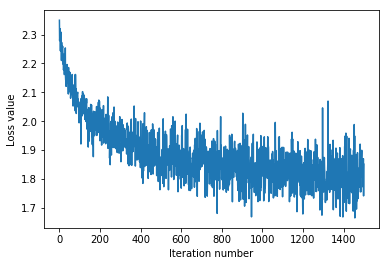

In [10]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [11]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.38224489795918365
validation accuracy: 0.403


## Optimize the softmax classifier

You may copy and paste your optimization code from the SVM here.

In [12]:
np.finfo(float).eps

2.220446049250313e-16

In [13]:
from sklearn.model_selection import train_test_split
# ================================================================ #
# YOUR CODE HERE:
#   Train the SVM with different learning rates and evaluate on the
#     validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best VALIDATION accuracy corresponding to the best VALIDATION error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
#   Note: You do not need to modify SVM class for this section
# ================================================================ #
learning_rate = [1e-5,3.3e-5,1e-4,3.3e-4,1e-3,3.3e-3,1e-2]
val_acc = []
for i in range(len(learning_rate)):
    X_val_train ,X_val_test, y_val_train, y_val_test = train_test_split(X_val,y_val,test_size=0.2,\
                                                    random_state=int(np.random.randint(0,2**32-1,size=1)))
    num_classes = len(np.unique(y_val_train))
    num_features = X_val_train.shape[1]

    softmax = Softmax(dims=[num_classes, num_features])
    softmax.train(X_val_train, y_val_train, learning_rate[i], 1500, 200, False)
    val_acc.append(np.mean(np.equal(y_val_test, softmax.predict(X_val_test))))
    
val_max = max(val_acc)
index_max = val_acc.index(val_max)
print('The best validation accuracy is ', val_max, ', while the learning rate is ', learning_rate[index_max])
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


/home/dennis/Documents/PY_PROGRAM/UCLA_C247/HW2-code/HW2-code/nndl/softmax.py:139: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(np.true_divide(np.exp(np.sum(X * self.W[y],axis=1) - np.max(np.dot(X,self.W.T),axis=1)),np.sum(np.exp(np.dot(X,self.W.T) - np.max(np.dot(X,self.W.T),axis=1).reshape(num_train,1)),axis=1))))


The best validation accuracy is  0.335 , while the learning rate is  1e-05
